# Project II

## Set up environment


In [5]:
#import all packages needed
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets

import xgboost as xgb
from datetime import datetime
from dateutil.relativedelta import relativedelta


# Load sklearn packages
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier # Load k-NN from sklearn
from sklearn.preprocessing import StandardScaler


from utils.helper_functions import *




In [6]:
mimic_train = pd.read_csv("Data/mimic_train_2.csv")
mimic_test = pd.read_csv("Data/Xtest_2.csv")
mimic_diagnosis = pd.read_csv("/home/oliver/Documents/Computational_Machine_Learning/Data/MIMIC_diagnoses.csv") #extending the data

In [7]:
mimic_train.head()

,Unnamed: 0,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,-63883.78340,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,49121,MICU,6.1397
1,15798,0,44346,140114,250021,74.0,114.0,92.204082,87.0,160.0,...,-56421.13544,EMERGENCY,Private,EPISCOPALIAN,DIVORCED,WHITE,S/P PEDESTRIAN STRUCK,80620,TSICU,10.2897
2,2129,0,92438,118589,288511,59.0,89.0,70.581395,88.0,160.0,...,-60754.35504,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,STERNAL WOUND INFECTION,99859,CSRU,5.8080
3,17053,1,83663,125553,278204,75.0,86.0,80.400000,74.0,102.0,...,-56609.91884,EMERGENCY,Private,CATHOLIC,MARRIED,BLACK/AFRICAN AMERICAN,SEPSIS,27652,MICU,2.3536
4,11609,0,85941,181409,292581,77.0,107.0,91.020408,95.0,150.0,...,-59200.37377,EMERGENCY,Medicaid,NOT SPECIFIED,DIVORCED,WHITE,BILE LEAK,9974,MICU,19.3935


## Inspect and clean obvious columns

By reading through the assigment and inspecting the data by using .head() or .columns, we can already see that we can prepare and get rid of some columns:

In [8]:
print("dimensions of train: ", mimic_train.shape , "\ndimensions of test: ", mimic_test.shape)

dimensions of train:  (8000, 45) 
dimensions of test:  (12885, 43)


In [9]:
pd.set_option('display.max_columns', None)
mimic_train.head()


,Unnamed: 0,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.000000,62.0,95.0,76.142857,71.0,107.0,88.000000,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.900000,88.0,200.0,155.000000,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.78340,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,49121,MICU,6.1397
1,15798,0,44346,140114,250021,74.0,114.0,92.204082,87.0,160.0,122.000000,35.0,75.0,53.020000,16.0,103.0,70.384615,7.0,28.0,17.735849,36.611111,38.111111,37.511905,63.0,100.0,95.897959,153.0,213.0,187.000000,F,2103-03-10 00:00:00,NaN,2165-04-04 02:25:00,2165-04-16 14:41:00,NaN,-56421.13544,EMERGENCY,Private,EPISCOPALIAN,DIVORCED,WHITE,S/P PEDESTRIAN STRUCK,80620,TSICU,10.2897
2,2129,0,92438,118589,288511,59.0,89.0,70.581395,88.0,160.0,120.933333,43.0,70.0,51.688889,55.0,99.0,69.155556,7.0,16.0,13.716981,36.000000,38.388889,37.175926,97.0,100.0,99.674419,73.0,113.0,88.333333,M,2104-08-12 00:00:00,NaN,2177-06-23 12:33:00,2177-07-07 12:45:00,NaN,-60754.35504,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,STERNAL WOUND INFECTION,99859,CSRU,5.8080
3,17053,1,83663,125553,278204,75.0,86.0,80.400000,74.0,102.0,85.227273,47.0,69.0,59.636364,54.0,77.0,66.000000,5.0,19.0,11.000000,35.111111,36.777778,35.981481,91.0,97.0,93.809524,68.0,68.0,68.000000,M,2105-07-06 00:00:00,2167-07-19 00:00:00,2167-07-17 21:34:00,2167-07-19 21:34:00,2167-07-19 21:34:00,-56609.91884,EMERGENCY,Private,CATHOLIC,MARRIED,BLACK/AFRICAN AMERICAN,SEPSIS,27652,MICU,2.3536
4,11609,0,85941,181409,292581,77.0,107.0,91.020408,95.0,150.0,108.625000,39.0,132.0,57.500000,56.0,136.0,71.959184,13.0,27.0,18.854545,36.777778,38.000000,37.487654,92.0,99.0,95.673469,73.0,117.0,92.666667,M,2112-12-12 00:00:00,2177-03-05 00:00:00,2174-03-09 12:17:00,2174-03-31 16:00:00,NaN,-59200.37377,EMERGENCY,Medicaid,NOT SPECIFIED,DIVORCED,WHITE,BILE LEAK,9974,MICU,19.3935


In [10]:
mimic_test.head()

,X,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,1,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,2,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
2,3,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
3,4,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
4,5,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU


In [11]:
mimic_diagnosis.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


Before incorporating the extended mimic_diagnosis set, we look through it manually and sort out the values which we infer we don't know the first day of a patient in an ICU. For example:

- ICD9_CODE: 7681;Fet death-anoxia dur lab;Fetal death from asphyxia or anoxia during labor

We cannot use this in our predictions, so we need to drop it.
We gatherd the following ICD9_CODES which should be removed:

More precicely, here is a list of diagnosis we excluded:

- 34882,Brain death,Brain death
- 7681;Fet death-anoxia dur lab;Fetal death from asphyxia or anoxia during labor
- 7989,Unattended death,Unattended death
- 7981,Instantaneous death,Instantaneous death
- 7616,Maternal death aff NB,Maternal death affecting fetus or newborn
- 7680,Fetal death-anoxia NOS,Fetal death from asphyxia or anoxia before onset of labor or at unspecified time
- 65641,Intrauter death-deliver,"Intrauterine death, affecting management of mother, delivered, with or without m ention of antepartum condition"
- 65640,Intrauterine death-unsp,"Intrauterine death, affecting management of mother, unspecified as to episode of care or not applicable"
- 7982,Death within 24 hr sympt,"Death occurring in less than 24 hours from onset of symptoms, not otherwise explained"
- 7681,Fet death-anoxia dur lab,Fetal death from asphyxia or anoxia during labor
- 65643,Intrauter death-antepart,"Intrauterine death, affecting management of mother, antepartum condition or complication"
- 7980,Sudden infant death synd,Sudden infant death syndrome



In [12]:
#values_to_exclude = [34882, 7681, 7989, 7981, 7616, 7680, 65641, 65640, 7982, 7681, 65643, 7980]
#values_to_exclude_str = [str(value) for value in values_to_exclude]
#mimic_diagnosis = mimic_diagnosis[~mimic_diagnosis['ICD9_CODE'].isin(values_to_exclude_str)]

#mimic_diagnosis.shape

In [13]:
# Number of unique values in a specific column
unique_count_train = mimic_train['ICD9_diagnosis'].nunique()
unique_count_diagnosis = mimic_diagnosis['ICD9_CODE'].nunique()

print(f"{unique_count_train} unique diagnoses of mimic train,  {unique_count_diagnosis} unique diagnoses of mimic diagnosis ")


1247 unique diagnoses of mimic train,  6984 unique diagnoses of mimic diagnosis 


## Data Wrangling

### Categorical predictors, ICD9_diagnosis and frequency plus target encoding

After inspecting the data, we realize that we have some categorical columns which require our attention.
Columns like gender and ethnicity are not a big problem since we could just dummify those.

ICD9_diagnosis however requires cautious handing since we have almost 7000 unique values. This would result into about 7000 columns when dummifying. One way to prevent the "issue" of having such high dimensions is by doing something like frequency encoding. This means we count the number of times each diagnosis is being seen in the dataset and assign that value to a patient.

So we decided to apply frequency encoding PLUS TARGET ENCODING for the extended diagnoses values, which will be our main predictor. 

As we have seen in the last project, frequency encoding has its drawbacks:
For example, frequent diagnoses are not necessarily indicative of high mortality. For instance, common conditions like "asthma" or "low-level infections" might be frequently recorded but not always associated with high mortality rates.

Target encoding, in which we replace categories with the mean of the target variable (the Length of Stay), can address some of these drawbacks. By encoding categories based on the actual target value (i.e., LOS), it allows the model to learn the relationship between the diagnosis and the outcome, rather than assuming that frequency alone is a good predictor.


## Target encoding

Before doing any encoding, we merge the mimic_diagnosis dataset with the train and test dataset:

In [14]:
mimic_train_freq=mimic_train.copy()
mimic_test_freq=mimic_test.copy()

mimic_train_freq = mimic_train_freq.drop(columns='ICD9_diagnosis') #we have it in mimic diagnosis anyways
mimic_test_freq = mimic_test_freq.drop(columns='ICD9_diagnosis')

#it should be named the same as in train and test
mimic_diagnosis.rename(columns={'SUBJECT_ID': 'subject_id', 'HADM_ID': 'hadm_id', 'ICD9_CODE': 'ICD9_diagnosis'}, inplace=True)
# Step 1: Merge the additional diagnoses with train and test sets on SUBJECT_ID and HADM_ID
mimic_train_freq = mimic_train_freq.merge(mimic_diagnosis[['subject_id', 'hadm_id', 'SEQ_NUM', 'ICD9_diagnosis']], on=['subject_id', 'hadm_id'], how='left')
mimic_test_freq = mimic_test_freq.merge(mimic_diagnosis[['subject_id', 'hadm_id', 'SEQ_NUM', 'ICD9_diagnosis']], on=['subject_id', 'hadm_id'], how='left')

# Fill any missing SEQ_NUM values in test or train with 0 (if a patient has no additional diagnoses)
mimic_train_freq['SEQ_NUM'].fillna(0, inplace=True)
mimic_test_freq['SEQ_NUM'].fillna(0, inplace=True)


/tmp/ipykernel_50340/1002396392.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mimic_train_freq['SEQ_NUM'].fillna(0, inplace=True)
/tmp/ipykernel_50340/1002396392.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [15]:
mimic_train_freq #We see how the number of rows exploded since each patient can have many diagnoses

,Unnamed: 0,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,FIRST_CAREUNIT,LOS,SEQ_NUM,ICD9_diagnosis
0,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.000000,62.0,95.0,76.142857,71.0,107.0,88.000000,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.90,88.0,200.0,155.000000,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.78340,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,1.0,49121
1,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.000000,62.0,95.0,76.142857,71.0,107.0,88.000000,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.90,88.0,200.0,155.000000,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.78340,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,2.0,51884
2,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.000000,62.0,95.0,76.142857,71.0,107.0,88.000000,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.90,88.0,200.0,155.000000,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.78340,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,3.0,42823
3,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.000000,62.0,95.0,76.142857,71.0,107.0,88.000000,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.90,88.0,200.0,155.000000,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.78340,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,4.0,4254
4,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.000000,62.0,95.0,76.142857,71.0,107.0,88.000000,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.90,88.0,200.0,155.000000,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.78340,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,5.0,2639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118879,18386,0,53084,103543,213395,71.0,117.0,90.933333,78.0,151.0,110.022222,30.0,132.0,56.288889,43.0,136.0,69.022222,12.0,30.0,19.704918,36.055556,37.833333,37.212121,85.0,100.0,96.85,86.0,243.0,142.555556,M,2067-11-08 00:00:00,2154-10-04 00:00:00,2153-03-25 22:21:00,2153-04-04 15:24:00,NaN,-52319.78283,EMERGENCY,Medicare,NOT SPECIFIED,MARRIED,WHITE,NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION...,CCU,3.6509,13.0,43330
118880,18386,0,53084,103543,213395,71.0,117.0,90.933333,78.0,151.0,110.022222,30.0,132.0,56.288889,43.0,136.0,69.022222,12.0,30.0,19.704918,36.055556,37.833333,37.212121,85.0,100.0,96.85,86.0,243.0,142.555556,M,2067-11-08 00:00:00,2154-10-04 00:00:00,2153-03-25 22:21:00,2153-04-04 15:24:00,NaN,-52319.78283,EMERGENCY,Medicare,NOT SPECIFIED,MARRIED,WHITE,NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION...,CCU,3.6509,14.0,2113
118881,18386,0,53084,103543,213395,71.0,117.0,90.933333,78.0,151.0,110.022222,30.0,132.0,56.288889,43.0,136.0,69.022222,12.0,30.0,19.704918,36.055556,37.833333,37.212121,85.0,100.0,96.85,86.0,243.0,142.555556,M,2067-11-08 00:00:00,2154-10-04 00:00:00,2153-03-25 22:21:00,2153-04-04 15:24:00,NaN,-52319.78283,EMERGENCY,Medicare,NOT SPECIFIED,MARRIED,WHITE,NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION...,CCU,

In [16]:
# Assuming you have mimic_train and mimic_test loaded as DataFrames

# Step 1: Calculate the mean LOS for each unique value of ICD9_diagnosis in the training set
icd9_target_mean = mimic_train_freq.groupby('ICD9_diagnosis')['LOS'].mean()

# Step 2: Apply the encoding to both training and test sets
# Replace each ICD9_diagnosis in mimic_train with its corresponding mean LOS
mimic_train['ICD9_target_encoded'] = mimic_train_freq['ICD9_diagnosis'].map(icd9_target_mean)

# Replace each ICD9_diagnosis in mimic_test with the mean LOS from mimic_train
# Any ICD9_diagnosis not seen in mimic_train will be encoded as the overall mean of LOS in mimic_train
overall_mean = mimic_train['LOS'].mean()
mimic_test['ICD9_target_encoded'] = mimic_test_freq['ICD9_diagnosis'].map(icd9_target_mean).fillna(overall_mean)

# Optionally, drop the original ICD9_diagnosis column from both datasets if it's no longer needed
#mimic_train = mimic_train.drop(columns=['ICD9_diagnosis'])
#mimic_test = mimic_test.drop(columns=['ICD9_diagnosis'])

# Display the first few rows to verify
print("Training set:\n", mimic_train.head())
print("Testing set:\n", mimic_test.head())

Training set:
    Unnamed: 0  HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  \
0        6733                     0       77502   151200      299699   
1       15798                     0       44346   140114      250021   
2        2129                     0       92438   118589      288511   
3       17053                     1       83663   125553      278204   
4       11609                     0       85941   181409      292581   

   HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  \
0           89.0          116.0      102.677419       97.0      150.0   
1           74.0          114.0       92.204082       87.0      160.0   
2           59.0           89.0       70.581395       88.0      160.0   
3           75.0           86.0       80.400000       74.0      102.0   
4           77.0          107.0       91.020408       95.0      150.0   

   SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  MeanBP_Max  \
0  126.000000        62.0        95

In [17]:
mimic_test

,X,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,ICD9_target_encoded
0,1,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.245388
1,2,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,7.775552
2,3,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,4.926539
3,4,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,4.588194
4,5,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,6.855212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12880,20879,28519,140024,241050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,140.0,140.000000,F,2100-05-31 00:00:00,2180-11-03 00:00:00,2180-04-30 14:48:00,2180-05-08 16:58:00,NaN,-62710.83211,EMERGENCY,Medicare,GREEK ORTHODOX,MARRIED,WHITE,CEREBROVASCULAR ACCIDENT,431,SICU,2.102400
12881,20880,2338,145012,233204,80.0,85.0,81.947368,81.0,107.0,94.176471,52.0,69.0,58.823529,60.0,78.0,66.882353,11.0,20.0,14.944444,36.333333,37.000000,36.666667,97.0,100.0,98.631579,102.0,102.0,102.000000,M,2097-09-24 00:00:00,2159-10-29 00:00:00,2158-12-15 23:01:00,2158-12-22 15:45:00,NaN,-54809.57459,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,S/P ARREST,4271,MICU,3.523675
12882,20881,28043,135417,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,41.0,102.0,69.285714,10.0,23.0,15.420000,35.555556,36.611111,36.155556,97.0,100.0,99.833333,68.0,139.0,103.571429,M,2088-12-15 00:00:00,2177-02-02 00:00:00,2176-06-17 06:36:00,2176-07-04 14:01:00,NaN,-60714.92678,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ALTERED MENTAL STATUS,3229,MICU,3.012332
12883,20883,47492,152608,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,66.0,95.0,78.500000,14.0,27.0,18.166667,36.055556,37.277778,37.007937,97.0,100.0,99.200000,51.0,460.0,190.000000,F,2055-11-27 00:00:00,NaN,2118-10-18 17:54:00,2118-10-21 15:37:00,NaN,-39830.10848,EMERGENCY,Private,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,HYPOGLYCEMIA,24980,MICU,4.053733


### Frequency encoding

Common diagnoses (i.e., those with high frequency counts) often include conditions that are well-documented and potentially carry a known risk profile. For example, certain heart conditions or infections frequently lead to ICU admissions, and the mortality risk associated with them might be well-understood.

If common diagnoses in the ICU dataset correlate with higher or lower mortality rates, then the frequency count serves as an indirect indicator of that risk. For instance, a diagnosis like “severe sepsis” might appear frequently in ICU records, and its association with high mortality makes it a significant predictor for your model.

In [18]:
mimic_train_freq=mimic_train.copy()
mimic_test_freq=mimic_test.copy()

mimic_train_freq = mimic_train_freq.drop(columns='ICD9_diagnosis') #we have it in mimic diagnosis anyways
mimic_test_freq = mimic_test_freq.drop(columns='ICD9_diagnosis')

#it should be named the same as in train and test
mimic_diagnosis.rename(columns={'SUBJECT_ID': 'subject_id', 'HADM_ID': 'hadm_id', 'ICD9_CODE': 'ICD9_diagnosis'}, inplace=True)
# Step 1: Merge the additional diagnoses with train and test sets on SUBJECT_ID and HADM_ID
mimic_train_freq = mimic_train_freq.merge(mimic_diagnosis[['subject_id', 'hadm_id', 'SEQ_NUM', 'ICD9_diagnosis']], on=['subject_id', 'hadm_id'], how='left')
mimic_test_freq = mimic_test_freq.merge(mimic_diagnosis[['subject_id', 'hadm_id', 'SEQ_NUM', 'ICD9_diagnosis']], on=['subject_id', 'hadm_id'], how='left')

# Fill any missing SEQ_NUM values in test or train with 0 (if a patient has no additional diagnoses)
mimic_train_freq['SEQ_NUM'].fillna(0, inplace=True)
mimic_test_freq['SEQ_NUM'].fillna(0, inplace=True)


/tmp/ipykernel_50340/1002396392.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mimic_train_freq['SEQ_NUM'].fillna(0, inplace=True)
/tmp/ipykernel_50340/1002396392.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

We now do the frequency encoding below.

Additionally, some ICD9 codes may be present in the test set but not in the training set. So we map these values to a default of 0 as it effectively treats these categories as rare. This ensures that the model can handle unseen values consistently.


In [19]:
diagnosis_counts = mimic_train_freq['ICD9_diagnosis'].value_counts()

# Map the count encoding to both training and test datasets
mimic_train_freq['ICD9_encoded'] = mimic_train_freq['ICD9_diagnosis'].map(diagnosis_counts)
mimic_test_freq['ICD9_encoded'] = mimic_test_freq['ICD9_diagnosis'].map(diagnosis_counts)

# Handle any ICD9 codes in the test set that may not be in the training set (e.g., set to 0)
mimic_test_freq['ICD9_encoded'].fillna(0, inplace=True)


# Drop the 'SEQ_NUM' column, as do not need it
mimic_train_freq.drop(['SEQ_NUM'], axis=1, inplace=True)
mimic_test_freq.drop(['SEQ_NUM'], axis=1, inplace=True)


/tmp/ipykernel_50340/3235106073.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mimic_test_freq['ICD9_encoded'].fillna(0, inplace=True)


In [20]:
null_rows = mimic_train_freq[mimic_train_freq['ICD9_encoded'].isnull()]
print(null_rows)

Empty DataFrame
Columns: [Unnamed: 0, HOSPITAL_EXPIRE_FLAG, subject_id, hadm_id, icustay_id, HeartRate_Min, HeartRate_Max, HeartRate_Mean, SysBP_Min, SysBP_Max, SysBP_Mean, DiasBP_Min, DiasBP_Max, DiasBP_Mean, MeanBP_Min, MeanBP_Max, MeanBP_Mean, RespRate_Min, RespRate_Max, RespRate_Mean, TempC_Min, TempC_Max, TempC_Mean, SpO2_Min, SpO2_Max, SpO2_Mean, Glucose_Min, Glucose_Max, Glucose_Mean, GENDER, DOB, DOD, ADMITTIME, DISCHTIME, DEATHTIME, Diff, ADMISSION_TYPE, INSURANCE, RELIGION, MARITAL_STATUS, ETHNICITY, DIAGNOSIS, FIRST_CAREUNIT, LOS, ICD9_target_encoded, ICD9_diagnosis, ICD9_encoded]
Index: []


In [21]:
mimic_train_freq.head()

,Unnamed: 0,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,FIRST_CAREUNIT,LOS,ICD9_target_encoded,ICD9_diagnosis,ICD9_encoded
0,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.0,62.0,95.0,76.142857,71.0,107.0,88.0,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.9,88.0,200.0,155.0,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.7834,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,4.598965,49121,204
1,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.0,62.0,95.0,76.142857,71.0,107.0,88.0,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.9,88.0,200.0,155.0,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.7834,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,4.598965,51884,102
2,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.0,62.0,95.0,76.142857,71.0,107.0,88.0,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.9,88.0,200.0,155.0,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.7834,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,4.598965,42823,350
3,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.0,62.0,95.0,76.142857,71.0,107.0,88.0,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.9,88.0,200.0,155.0,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.7834,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,4.598965,4254,314
4,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,126.0,62.0,95.0,76.142857,71.0,107.0,88.0,16.0,28.0,19.903226,35.611111,36.444444,36.064815,86.0,100.0,97.9,88.0,200.0,155.0,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,-63883.7834,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,MICU,6.1397,4.598965,2639,289


We now aggregate with sum for ICD9_encoded. Because we want to have one encoded value per client. We mainly changed that we use LOS instead of HOSITAL_EXPIRE_FLAG here!

In [22]:

# Aggregate with sum for ICD9_encoded and 'first' for all other columns
mimic_train_freq = mimic_train_freq.groupby(['subject_id', 'hadm_id', 'icustay_id'], as_index=False).agg({
    #'HOSPITAL_EXPIRE_FLAG': 'first',
    'LOS': 'first',
    'ICD9_encoded': 'sum',             # Sum up all encoded diagnosis counts for the ICU stay
    #'HeartRate_Min': 'first',
    #'HeartRate_Max': 'first',
    'HeartRate_Mean': 'first',
    #'SysBP_Min': 'first',
    #'SysBP_Max': 'first',
    'SysBP_Mean': 'first',
    #'DiasBP_Min': 'first',
    #'DiasBP_Max': 'first',
    'DiasBP_Mean': 'first',
    #'MeanBP_Min': 'first',
    #'MeanBP_Max': 'first',
    'MeanBP_Mean': 'first',
    #'RespRate_Min': 'first',
    #'RespRate_Max': 'first',
    'RespRate_Mean': 'first',
    #'TempC_Min': 'first',
    #'TempC_Max': 'first',
    'TempC_Mean': 'first',
    #'SpO2_Min': 'first',
    #'SpO2_Max': 'first',
    'SpO2_Mean': 'first',
    #'Glucose_Min': 'first',
    #'Glucose_Max': 'first',
    'Glucose_Mean': 'first',
    'GENDER': 'first',
    'DOB': 'first',
    'ADMITTIME': 'first',
    'Diff': 'first',
    'ADMISSION_TYPE': 'first',
    'INSURANCE': 'first',
    'RELIGION': 'first',
    'ETHNICITY': 'first',
    'ICD9_diagnosis': 'first',
    #'DIAGNOSIS': 'first',
    'FIRST_CAREUNIT': 'first',
    'ICD9_target_encoded':'first'
    # Add any remaining columns here, using 'first' for all except 'ICD9_encoded'
})
# Aggregate with sum for ICD9_encoded and 'first' for all other columns
mimic_test_freq = mimic_test_freq.groupby(['subject_id', 'hadm_id', 'icustay_id'], as_index=False).agg({
    #'HOSPITAL_EXPIRE_FLAG': 'first'
    'ICD9_encoded': 'sum',             # Sum up all encoded diagnosis counts for the ICU stay
    #'HeartRate_Min': 'first',
    #'HeartRate_Max': 'first',
    'HeartRate_Mean': 'first',
    #'SysBP_Min': 'first',
    #'SysBP_Max': 'first',
    'SysBP_Mean': 'first',
    #'DiasBP_Min': 'first',
    #'DiasBP_Max': 'first',
    'DiasBP_Mean': 'first',
    #'MeanBP_Min': 'first',
    #'MeanBP_Max': 'first',
    'MeanBP_Mean': 'first',
    #'RespRate_Min': 'first',
    #'RespRate_Max': 'first',
    'RespRate_Mean': 'first',
    #'TempC_Min': 'first',
    #'TempC_Max': 'first',
    'TempC_Mean': 'first',
    #'SpO2_Min': 'first',
    #'SpO2_Max': 'first',
    'SpO2_Mean': 'first',
    #'Glucose_Min': 'first',
    #'Glucose_Max': 'first',
    'Glucose_Mean': 'first',
    'GENDER': 'first',
    'DOB': 'first',
    'ADMITTIME': 'first',
    'Diff': 'first',
    'ADMISSION_TYPE': 'first',
    'INSURANCE': 'first',
    'RELIGION': 'first',
    'ETHNICITY': 'first',
    #'DIAGNOSIS': 'first',
    'ICD9_diagnosis': 'first',
    'FIRST_CAREUNIT': 'first',
    'ICD9_target_encoded':'first'
    # Add any remaining columns here, using 'first' for all except 'ICD9_encoded'
})


In [23]:
mimic_train_freq.shape

(8000, 24)

In [24]:
mimic_test_freq.shape

(12885, 23)

In [25]:
mimic_test_freq.head()

,subject_id,hadm_id,icustay_id,ICD9_encoded,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,ETHNICITY,ICD9_diagnosis,FIRST_CAREUNIT,ICD9_target_encoded
0,23,124321,234044,8391.0,76.694444,122.180000,64.860000,83.978723,17.114286,36.301587,98.114286,133.200000,M,2082-07-17 00:00:00,2157-10-18 19:34:00,-53495.34640,EMERGENCY,Medicare,CATHOLIC,WHITE,2252,SICU,4.362833
1,34,144319,290505,6776.0,55.864865,128.055556,59.888889,76.166667,17.394737,36.319444,95.878788,117.333333,M,1886-07-18 00:00:00,2191-02-23 05:23:00,-65247.46131,EMERGENCY,Medicare,CATHOLIC,WHITE,42789,CCU,4.681025
2,109,102024,240251,5597.0,96.620690,156.428571,105.107143,117.035714,19.333333,36.880952,99.733333,110.000000,F,2117-08-07 00:00:00,2142-05-20 12:59:00,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,3.963706
3,109,113189,291270,3828.0,83.925926,135.500000,85.307692,97.961538,18.291667,36.472222,98.230769,81.000000,F,2117-08-07 00:00:00,2142-02-14 10:42:00,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,7.709674
4,109,124657,261180,2506.0,95.666667,165.366667,105.166667,118.633333,18.933333,37.255556,98.400000,142.000000,F,2117-08-07 00:00:00,2142-01-14 17:34:00,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,SICU,3.913048


In [26]:
# We used _freq until now but we are sure that it works now so we assign it to our final dataset mimic_train and mimic_test
# ASSIGN IT TO FINAL DATASET

mimic_train=mimic_train_freq
mimic_test=mimic_test_freq

We drop some columns which we are required to drop or also columns that should just not have any impact. Marital_Status is dropped because we assume that this does not effect the death rate and DIAGNOSIS is encoded in ICD9_diagnosis anyways. This code is commented out because we do not have these columns anymore anyways. Looking closely, we see how we did not incroporate these columns in our aggregate block above. We also excluded all the min/max value columns as we have the mean column of that value anyways. These different types are correlated as it is easy to argue. Thus, including max, min and mean at the same time would introduce collinarity which we do not want.


Note that we could still do much more to improve our features: For example, we could do PCA to reduce the dimensions (which would be specially usable when dummifying because we have a lot of dimension) and could also solve the  max,min mean problem. However, we decided to focus on keeping it simple and intuitive, easily interpretable and understandable as this is the main goal of this project.



In [27]:
'''
drop_columns =['Unnamed: 0','DOD', 'DISCHTIME', 'DEATHTIME', 'LOS', 'MARITAL_STATUS', 'DIAGNOSIS']
## Drop the specified categorical columns in both training and test sets
mimic_train = mimic_train.drop(columns=drop_columns)
mimic_test = mimic_test.drop(columns=drop_columns)

print("dimensions of train after dropping: ", mimic_train.shape , "\ndimensions of test after dropping: ", mimic_test.shape)
'''

'\ndrop_columns =[\'Unnamed: 0\',\'DOD\', \'DISCHTIME\', \'DEATHTIME\', \'LOS\', \'MARITAL_STATUS\', \'DIAGNOSIS\']\n## Drop the specified categorical columns in both training and test sets\nmimic_train = mimic_train.drop(columns=drop_columns)\nmimic_test = mimic_test.drop(columns=drop_columns)\n\nprint("dimensions of train after dropping: ", mimic_train.shape , "\ndimensions of test after dropping: ", mimic_test.shape)\n'

### Dropping NULLs

In [28]:
nulls=mimic_train.isnull().sum()
missing_data_col= mimic_train.columns[nulls>0]
missing_data_col

Index(['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean',
       'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean'],
      dtype='object')

Before we do any inputation, we drop features that have more than 50% missing values:

In [29]:
#let's drop columns for which there is hardly any data which makes data imputation hard
my_percentage = 0.5
#for drop_columns in mimic_train:
mimic_train.dropna(axis=1, thresh=round(my_percentage*len(mimic_train.index)))
mimic_test.dropna(axis=1, thresh=round(my_percentage*len(mimic_test.index)))


,subject_id,hadm_id,icustay_id,ICD9_encoded,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,ETHNICITY,ICD9_diagnosis,FIRST_CAREUNIT,ICD9_target_encoded
0,23,124321,234044,8391.0,76.694444,122.180000,64.860000,83.978723,17.114286,36.301587,98.114286,133.200000,M,2082-07-17 00:00:00,2157-10-18 19:34:00,-53495.34640,EMERGENCY,Medicare,CATHOLIC,WHITE,2252,SICU,4.362833
1,34,144319,290505,6776.0,55.864865,128.055556,59.888889,76.166667,17.394737,36.319444,95.878788,117.333333,M,1886-07-18 00:00:00,2191-02-23 05:23:00,-65247.46131,EMERGENCY,Medicare,CATHOLIC,WHITE,42789,CCU,4.681025
2,109,102024,240251,5597.0,96.620690,156.428571,105.107143,117.035714,19.333333,36.880952,99.733333,110.000000,F,2117-08-07 00:00:00,2142-05-20 12:59:00,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,3.963706
3,109,113189,291270,3828.0,83.925926,135.500000,85.307692,97.961538,18.291667,36.472222,98.230769,81.000000,F,2117-08-07 00:00:00,2142-02-14 10:42:00,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,7.709674
4,109,124657,261180,2506.0,95.666667,165.366667,105.166667,118.633333,18.933333,37.255556,98.400000,142.000000,F,2117-08-07 00:00:00,2142-01-14 17:34:00,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,SICU,3.913048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12880,99957,148574,257127,9315.0,72.517241,140.423077,69.615385,86.038462,22.310345,36.481481,95.103448,137.600000,M,2089-02-01 00:00:00,2157-02-20 22:56:00,-53430.18063,URGENT,Medicare,JEWISH,WHITE,3202,MICU,2.888092
12881,99965,101083,257338,4547.0,65.275862,124.703704,55.518519,73.296296,14.392857,36.444444,99.703704,145.000000,M,2125-03-29 00:00:00,2191-07-13 19:39:00,-65932.06439,EMERGENCY,Medicare,PROTESTANT QUAKER,WHITE,99811,SICU,4.365775
12882,99982,112748,275958,10313.0,78.333333,106.675676,59.250000,73.459459,16.941176,35.703704,96.444444,100.666667,M,2091-10-02 00:00:00,2157-01-05 17:27:00,-52874.94110,EMERGENCY,Medicare,CATHOLIC,WHITE,4280,CCU,3.986556
12883,99982,151454,221194,7050.0,83.782609,95.584906,53.811321,66.871795,14.416667,37.165591,98.956522,103.066667,M,2091-10-02 00:00:00,2156-11-28 11:56:00,-52874.94110,EMERGENCY,Medicare,CATHOLIC,WHITE,42823,CSRU,5.430934


We see how most columns which have missing values can be handled easily since they are all numeric and it is sensitive to impute missing values using means or median to keep things simple.
However, we have some categorical variables which must be dealth with in order to use them in the model!

### Data manipulation and imputation

In [30]:
mimic_train

,subject_id,hadm_id,icustay_id,LOS,ICD9_encoded,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,ETHNICITY,ICD9_diagnosis,FIRST_CAREUNIT,ICD9_target_encoded
0,36,165660,241249,4.3483,6688,82.255814,115.609756,64.634146,76.365854,18.354167,37.477778,93.720930,106.000000,M,2061-08-17 00:00:00,2134-05-10 11:30:00,-44995.11045,ELECTIVE,Medicare,NOT SPECIFIED,WHITE,55321,MICU,5.014758
1,85,112077,291697,1.9909,10156,103.357143,104.700000,58.500000,69.033333,28.928571,37.229167,98.214286,114.000000,M,2090-09-18 00:00:00,2167-07-25 18:49:00,-58009.61759,EMERGENCY,Medicare,CATHOLIC,WHITE,0389,MICU,2.843765
2,109,124398,249219,0.5434,2484,91.312500,169.466667,97.200000,98.909091,18.125000,36.805556,97.357143,74.000000,F,2117-08-07 00:00:00,2142-03-24 16:34:00,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,4.085626
3,109,131345,243978,0.9832,6451,87.038462,161.280000,102.040000,116.600000,19.653846,35.988889,98.720000,93.000000,F,2117-08-07 00:00:00,2141-09-05 20:04:00,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,5.299333
4,109,137510,246183,1.3503,4050,76.312500,142.054054,84.702703,98.777778,16.107143,36.122222,97.806452,74.000000,F,2117-08-07 00:00:00,2142-04-20 13:39:00,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,3.349721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,99955,108494,243255,5.6719,5069,73.795455,122.954545,70.431818,82.113636,15.418182,38.341270,99.645833,257.833333,M,2076-05-04 00:00:00,2139-07-14 02:31:00,-46786.61687,EMERGENCY,Private,CATHOLIC,BLACK/AFRICAN AMERICAN,4321,SICU,5.477936
7996,99966,167228,252173,1.7034,8055,60.086957,132.083333,60.833333,77.791667,14.909091,36.111111,96.700000,83.000000,M,2114-02-27 00:00:00,2191-08-23 23:16:00,-65790.92355,EMERGENCY,Medicare,NOT SPECIFIED,WHITE,4260,CCU,2.993684
7997,99983,117390,286606,1.0399,9862,74.230769,110.450000,60.700000,74.700000,17.960000,36.574074,96.880000,120.666667,M,2114-09-29 00:00:00,2193-04-26 11:35:00,-66060.93291,EMERGENCY,Medicare,PROTESTANT QUAKER,UNKNOWN/NOT SPECIFIED,41001,CCU,3.746629
7998,99985,176670,279638,11.2998,9089,88.522727,116.790698,59.000000,76.604651,22.018182,38.064815,97.090909,106.500000,M,2127-04-08 00:00:00,2181-01-27 02:47:00,-61472.49049,EMERGENCY,Private,JEWISH,WHITE,0389,MICU,3.892200


### Dates, dummifying and dropping non-numeric non-boolean


As mentioned before, we now convert our categorical features into booleans(0/1's) to make it possible to use it for predictions:

We then select specifically only booleans and numeric datatypes, getting rid of other columns that we have not converted in such a way that it can be used for predictions. (e.g. timestamps) 

Before doing this, we inspect DOB and ADMITTIME to create something meaningful (Age) out of it.

We convert it to datetimes to compute the age:

In [31]:
mimic_test['ADMITTIME'] = pd.to_datetime(mimic_test['ADMITTIME']).dt.year
mimic_test['DOB'] = pd.to_datetime(mimic_test['DOB']).dt.year

# Calculate the difference in hours (or days, depending on your preference)
mimic_test['Age'] = (mimic_test['ADMITTIME']- mimic_test['DOB'])

# Do it with train:

mimic_train['ADMITTIME'] = pd.to_datetime(mimic_train['ADMITTIME']).dt.year
mimic_train['DOB'] = pd.to_datetime(mimic_train['DOB']).dt.year

# Calculate the difference in hours (or days, depending on your preference)
mimic_train['Age'] = (mimic_train['ADMITTIME']- mimic_train['DOB'])


In [32]:
mimic_train.head()

,subject_id,hadm_id,icustay_id,LOS,ICD9_encoded,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,ETHNICITY,ICD9_diagnosis,FIRST_CAREUNIT,ICD9_target_encoded,Age
0,36,165660,241249,4.3483,6688,82.255814,115.609756,64.634146,76.365854,18.354167,37.477778,93.720930,106.0,M,2061,2134,-44995.11045,ELECTIVE,Medicare,NOT SPECIFIED,WHITE,55321,MICU,5.014758,73
1,85,112077,291697,1.9909,10156,103.357143,104.700000,58.500000,69.033333,28.928571,37.229167,98.214286,114.0,M,2090,2167,-58009.61759,EMERGENCY,Medicare,CATHOLIC,WHITE,0389,MICU,2.843765,77
2,109,124398,249219,0.5434,2484,91.312500,169.466667,97.200000,98.909091,18.125000,36.805556,97.357143,74.0,F,2117,2142,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,4.085626,25
3,109,131345,243978,0.9832,6451,87.038462,161.280000,102.040000,116.600000,19.653846,35.988889,98.720000,93.0,F,2117,2141,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,5.299333,24
4,109,137510,246183,1.3503,4050,76.312500,142.054054,84.702703,98.777778,16.107143,36.122222,97.806452,74.0,F,2117,2142,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,3.349721,25


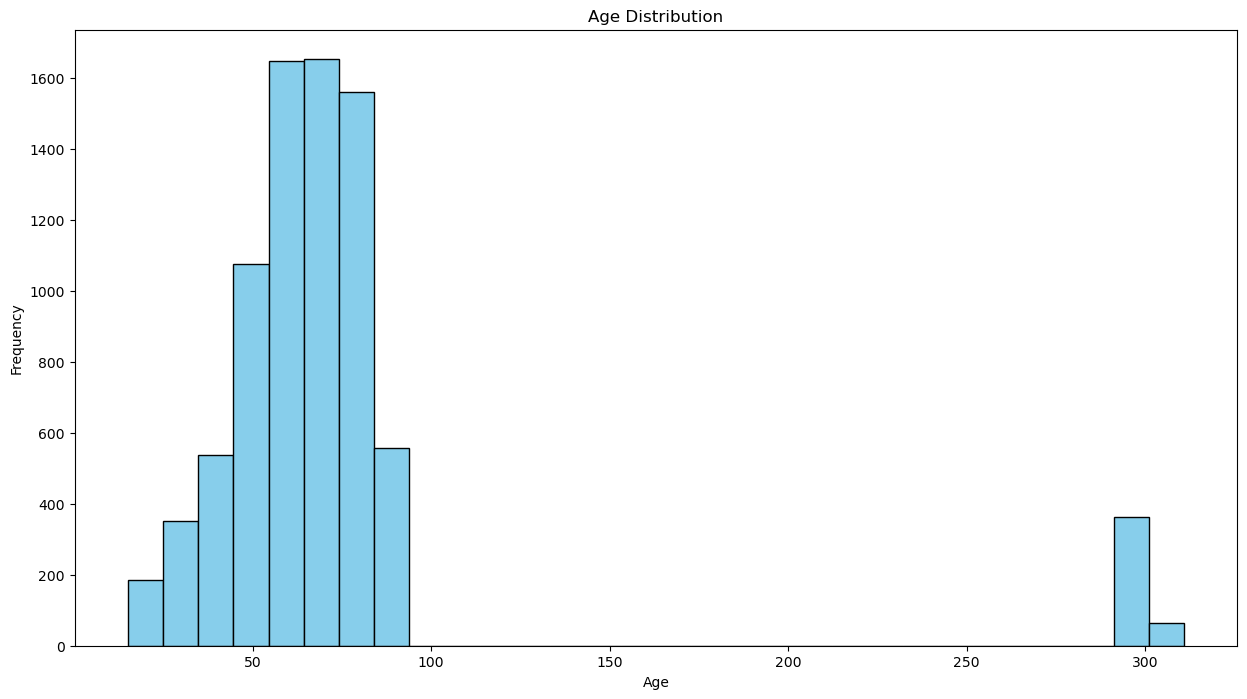

In [33]:
plt.figure(figsize=(15, 8))
plt.hist(mimic_train['Age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Taking a closer look, we observe the following: "Dates of birth for patients aged over 89 were shifted to obscure their true age and comply with HIPAA regulations" [source: https://physionet.org/content/mimiciii/1.4/]

So we create age groups (0 - 10, 10 - 20,... 90+) which we can then dummify and use for our predicitons

In [34]:
age_stats = mimic_train['Age'].describe()

print(age_stats)

count    8000.000000
mean       75.471250
std        55.849878
min        15.000000
25%        53.000000
50%        66.000000
75%        78.000000
max       311.000000
Name: Age, dtype: float64


In [35]:
mimic_train.shape

(8000, 25)

In [36]:
mimic_test.shape

(12885, 24)

In [37]:
# Define age bins and labels
# Define age bins and labels
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, float('inf')]  # setting last bin to capture all ages 90+
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

# Bin ages into age groups
mimic_train['AgeGroup'] = pd.cut(mimic_train['Age'], bins=age_bins, labels=age_labels, right=False)
mimic_test['AgeGroup'] = pd.cut(mimic_test['Age'], bins=age_bins, labels=age_labels, right=False)

# Create dummy variables for each age group, keeping other columns intact
mimic_train = pd.get_dummies(mimic_train, columns=['AgeGroup'], prefix='AgeGroup')
mimic_test = pd.get_dummies(mimic_test, columns=['AgeGroup'], prefix='AgeGroup')

mimic_train = mimic_train.drop(columns=['Age', 'ADMITTIME', 'DOB'], axis = 1)
mimic_test = mimic_test.drop(columns=['Age', 'ADMITTIME', 'DOB'], axis = 1)

print("added 10 age groups!")
print("dimensions of train after dummifying: ", mimic_train.shape , "\ndimensions of test and dummifying: ", mimic_test.shape)

added 10 age groups!
dimensions of train after dummifying:  (8000, 32) 
dimensions of test and dummifying:  (12885, 31)


In [38]:
mimic_train

,subject_id,hadm_id,icustay_id,LOS,ICD9_encoded,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,GENDER,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,ETHNICITY,ICD9_diagnosis,FIRST_CAREUNIT,ICD9_target_encoded,AgeGroup_0-9,AgeGroup_10-19,AgeGroup_20-29,AgeGroup_30-39,AgeGroup_40-49,AgeGroup_50-59,AgeGroup_60-69,AgeGroup_70-79,AgeGroup_80-89,AgeGroup_90+
0,36,165660,241249,4.3483,6688,82.255814,115.609756,64.634146,76.365854,18.354167,37.477778,93.720930,106.000000,M,-44995.11045,ELECTIVE,Medicare,NOT SPECIFIED,WHITE,55321,MICU,5.014758,False,False,False,False,False,False,False,True,False,False
1,85,112077,291697,1.9909,10156,103.357143,104.700000,58.500000,69.033333,28.928571,37.229167,98.214286,114.000000,M,-58009.61759,EMERGENCY,Medicare,CATHOLIC,WHITE,0389,MICU,2.843765,False,False,False,False,False,False,False,True,False,False
2,109,124398,249219,0.5434,2484,91.312500,169.466667,97.200000,98.909091,18.125000,36.805556,97.357143,74.000000,F,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,4.085626,False,False,True,False,False,False,False,False,False,False
3,109,131345,243978,0.9832,6451,87.038462,161.280000,102.040000,116.600000,19.653846,35.988889,98.720000,93.000000,F,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,5.299333,False,False,True,False,False,False,False,False,False,False
4,109,137510,246183,1.3503,4050,76.312500,142.054054,84.702703,98.777778,16.107143,36.122222,97.806452,74.000000,F,-48600.94168,EMERGENCY,Medicaid,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,40301,MICU,3.349721,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,99955,108494,243255,5.6719,5069,73.795455,122.954545,70.431818,82.113636,15.418182,38.341270,99.645833,257.833333,M,-46786.61687,EMERGENCY,Private,CATHOLIC,BLACK/AFRICAN AMERICAN,4321,SICU,5.477936,False,False,False,False,False,False,True,False,False,False
7996,99966,167228,252173,1.7034,8055,60.086957,132.083333,60.833333,77.791667,14.909091,36.111111,96.700000,83.000000,M,-65790.92355,EMERGENCY,Medicare,NOT SPECIFIED,WHITE,4260,CCU,2.993684,False,False,False,False,False,False,False,True,False,False
7997,99983,117390,286606,1.0399,9862,74.230769,110.450000,60.700000,74.700000,17.960000,36.574074,96.880000,120.666667,M,-66060.93291,EMERGENCY,Medicare,PROTESTANT QUAKER,UNKNOWN/NOT SPECIFIED,41001,CCU,3.746629,False,False,False,False,False,False,False,True,False,False
7998,99985,176670,279638,11.2998,9089,88.522727,116.790698,59.000000,76.604651,22.018182,38.064815,97.090909,106.500000,M,-61472.49049,EMERGENCY,Private,JEWISH,WHITE,0389,MICU,3.892200,False,False,False,False,False,True,False,False,False,False


We now dummify the remaining impactful categorical features. We leave out ICD9 and ethnicity as it barely adds to predictive power and makes the model much more complex

In [39]:
#dummify ICD9
#mimic_train = pd.get_dummies(mimic_train, prefix=['ICD9'], columns=['ICD9_diagnosis'])
#mimic_test = pd.get_dummies(mimic_test, prefix=['ICD9'], columns=['ICD9_diagnosis'])


#dummify gender, we comment this out since it made our model worse!
mimic_train = pd.get_dummies(mimic_train, prefix=['gender'], columns=['GENDER'])
mimic_test = pd.get_dummies(mimic_test, prefix=['gender'], columns=['GENDER'])

#dummify Admission type: We did not do this on the first few kaggle submissions but this logically increased accuracy a lot!
mimic_train = pd.get_dummies(mimic_train, prefix=['Admission_type'], columns=['ADMISSION_TYPE'])
mimic_test = pd.get_dummies(mimic_test, prefix=['Admission_type'], columns=['ADMISSION_TYPE'])

#dummify careunit:
mimic_train = pd.get_dummies(mimic_train, prefix=['First_careunit'], columns=['FIRST_CAREUNIT'])
mimic_test = pd.get_dummies(mimic_test, prefix=['First_careunit'], columns=['FIRST_CAREUNIT'])

#dummify insureance
mimic_train = pd.get_dummies(mimic_train, prefix=['insurance'], columns=['INSURANCE'])
mimic_test = pd.get_dummies(mimic_test, prefix=['insurance'], columns=['INSURANCE'])

#dummify ethnicity
#mimic_train = pd.get_dummies(mimic_train, prefix=['Ethnicity'], columns=['ETHNICITY'])
#mimic_test = pd.get_dummies(mimic_test, prefix=['Ethnicity'], columns=['ETHNICITY'])

#only select the columns which are numerical or boolean, this automatically gets rid of all the other non-numeric columns which we did not dummify
mimic_train_numerical = mimic_train.select_dtypes(include=['number', 'bool'])
mimic_test_numerical = mimic_test.select_dtypes(include=['number', 'bool'])


print("dimensions of train after dummifying: ", mimic_train_numerical.shape , "\ndimensions of test and dummifying: ", mimic_test_numerical.shape)

dimensions of train after dummifying:  (8000, 40) 
dimensions of test and dummifying:  (12885, 39)


In [40]:
pd.set_option('display.max_columns', 100)

mimic_train_numerical.head()

,subject_id,hadm_id,icustay_id,LOS,ICD9_encoded,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,Diff,ICD9_target_encoded,AgeGroup_0-9,AgeGroup_10-19,AgeGroup_20-29,AgeGroup_30-39,AgeGroup_40-49,AgeGroup_50-59,AgeGroup_60-69,AgeGroup_70-79,AgeGroup_80-89,AgeGroup_90+,gender_F,gender_M,Admission_type_ELECTIVE,Admission_type_EMERGENCY,Admission_type_URGENT,First_careunit_CCU,First_careunit_CSRU,First_careunit_MICU,First_careunit_SICU,First_careunit_TSICU,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay
0,36,165660,241249,4.3483,6688,82.255814,115.609756,64.634146,76.365854,18.354167,37.477778,93.720930,106.0,-44995.11045,5.014758,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False
1,85,112077,291697,1.9909,10156,103.357143,104.700000,58.500000,69.033333,28.928571,37.229167,98.214286,114.0,-58009.61759,2.843765,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False
2,109,124398,249219,0.5434,2484,91.312500,169.466667,97.200000,98.909091,18.125000,36.805556,97.357143,74.0,-48600.94168,4.085626,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False
3,109,131345,243978,0.9832,6451,87.038462,161.280000,102.040000,116.600000,19.653846,35.988889,98.720000,93.0,-48600.94168,5.299333,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False
4,109,137510,246183,1.3503,4050,76.312500,142.054054,84.702703,98.777778,16.107143,36.122222,97.806452,74.0,-48600.94168,3.349721,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False


We now start imputing for the (selected) features where it makes sense. For these, we use the median to impute missing values. They are all the numerical columns except columns that include IDs  or codes which can strictly also be numerical. For imputation, we also tried other methods such as mean or even 'Last observation' but it did not improve the model.

In [41]:
numerical_cols =['HeartRate_Mean','SysBP_Mean',
       'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean','TempC_Mean', 'SpO2_Mean','Glucose_Mean']
for my_col in numerical_cols:
  mimic_test_numerical[my_col].fillna(mimic_test_numerical[my_col].median(), inplace=True)
  mimic_train_numerical[my_col].fillna(mimic_train_numerical[my_col].median(), inplace=True)

/tmp/ipykernel_50340/2582468735.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mimic_test_numerical[my_col].fillna(mimic_test_numerical[my_col].median(), inplace=True)
/tmp/ipykernel_50340/2582468735.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [42]:
#let's see how many nulls we are left with
nulls=mimic_train_numerical.isnull().sum()
missing_data_col= mimic_train_numerical.columns[nulls>0]
missing_data_col #looks good!

Index([], dtype='object')

In [43]:
print("dimensions of train and dummifying: ", mimic_train_numerical.shape , "\ndimensions of test and dummifying: ", mimic_test_numerical.shape)

dimensions of train and dummifying:  (8000, 40) 
dimensions of test and dummifying:  (12885, 39)


As we can see by the dimensions of the train and test data, the columns of the test and train data do not align. However, this is essential since the data used for fitting must have the same number of columns as the data which we are using to predict. 
Therefore, we see which are the common columns and only select those to train and test our data:

### Training and Test dataset

To make the code simpler, we just use the training and testing dataset provided instead of splitting it again to check metrics more easily like in project I.

Let's drop the identifying columns which we used for data prep but we do not use for the model fitting

In [44]:
mimic_train_numerical=mimic_train_numerical.drop(['subject_id', 'hadm_id' ], axis=1) #only Icustay_id remains because we need these in our kaggle predictions
mimic_test_numerical=mimic_test_numerical.drop(['subject_id', 'hadm_id'], axis=1)#only Icustay_id remains because we need these in our kaggle predictions

In [45]:
# Split training set in X and y to fit a model
X = mimic_train_numerical.drop(['LOS'], axis=1)
y = mimic_train_numerical["LOS"]  # This is the classification outcome: dead/not dead
from sklearn.model_selection import train_test_split
X = X.loc[y.index]  # Ensure X is aligned with y after dropping NaNs

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
# align columns between training and test_data
common_columns = X.columns.intersection(mimic_test_numerical.columns)


X = X[common_columns]
X_test=mimic_test_numerical[common_columns]
# Check shapes to confirm alignment
print("Dimensions of data X to train the model: ", X.shape , "\nDimensions of data X used for Kaggle predictions: ", X_test.shape," yes! It matches!")


Dimensions of data X to train the model:  (8000, 37) 
Dimensions of data X used for Kaggle predictions:  (12885, 37)  yes! It matches!


We have to be careful when doing the predictions for Kaggle later. The columns of the Kaggle test data will not match ours. The dummyfying created different columns beceause we did not have the same observations in the columns that we dummified in the tst dataset and train dataset from Kaggle. We handle this below. Without this, we would not be able to make predictions!

Alternatively, we can take the union instead of only the common columns. However, it did not improve results and complicated the code, so we comment it out.

In [47]:
'''
missing_in_train = mimic_test_numerical.columns.difference(X_train.columns)
missing_in_test = X_train.columns.difference(mimic_test_numerical.columns)

# Add missing columns with default values (e.g., 0) to align datasets
for col in missing_in_train:
    X_train[col] = 0
    X_test[col] = 0  # Add to X_test as well

for col in missing_in_test:
    mimic_test_numerical[col] = 0

# Reorder columns to match training data
X_train = X_train.sort_index(axis=1)
X_pred = mimic_test_numerical[X_train.columns]
X_test = X_test.sort_index(axis=1)
# Confirm that the shapes match
print("Dimensions of data X to train the model: ", X_train.shape)
print("Dimensions of data X used for Kaggle predictions: ", X_pred.shape)
print("\nDimensions of test data X for predictions (of test data to see performance)", X_test.shape)

'''

'\nmissing_in_train = mimic_test_numerical.columns.difference(X_train.columns)\nmissing_in_test = X_train.columns.difference(mimic_test_numerical.columns)\n\n# Add missing columns with default values (e.g., 0) to align datasets\nfor col in missing_in_train:\n    X_train[col] = 0\n    X_test[col] = 0  # Add to X_test as well\n\nfor col in missing_in_test:\n    mimic_test_numerical[col] = 0\n\n# Reorder columns to match training data\nX_train = X_train.sort_index(axis=1)\nX_pred = mimic_test_numerical[X_train.columns]\nX_test = X_test.sort_index(axis=1)\n# Confirm that the shapes match\nprint("Dimensions of data X to train the model: ", X_train.shape)\nprint("Dimensions of data X used for Kaggle predictions: ", X_pred.shape)\nprint("\nDimensions of test data X for predictions (of test data to see performance)", X_test.shape)\n\n'

To minimize computational times and reduce dimensions, we have the otion of performing PCA. However, this did not improve predictions so we commented this out.

In [48]:
'''from sklearn.decomposition import PCA

# Initialize PCA with the number of components you want
n_components = 50  # Example number; adjust based on your needs
pca = PCA(n_components=n_components)

# Fit PCA on the training set and transform X_train
X = pca.fit_transform(X)

# Apply the same transformation to X_test
X_test = pca.transform(X_test)
'''

'from sklearn.decomposition import PCA\n\n# Initialize PCA with the number of components you want\nn_components = 50  # Example number; adjust based on your needs\npca = PCA(n_components=n_components)\n\n# Fit PCA on the training set and transform X_train\nX = pca.fit_transform(X)\n\n# Apply the same transformation to X_test\nX_test = pca.transform(X_test)\n'

## MODELING

### Decision Tree

As a first modeling approach, we fit a simle decision tree with different prameters.

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error
model = DecisionTreeRegressor()
model.fit(X,y) #fit without CV to test max_leaf_nodes
# Define the parameter grid for max_leaf_nodes
param_grid = {'max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

# Initialize the DecisionTreeRegressor
model = DecisionTreeRegressor()

# Set up Grid Search with cross-validation, using MSE as the scoring metric
grid_search_tree = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False))

# Fit GridSearchCV to find the best max_leaf_nodes
grid_search_tree.fit(X, y)

# The best value for max_leaf_nodes
print("Best max_leaf_nodes:", grid_search_tree.best_params_['max_leaf_nodes'])
print("Best cross-validated MSE:", -grid_search_tree.best_score_)


Best max_leaf_nodes: 10
Best cross-validated MSE: 32.47653336001806


To improve our model, we fit a random forest instead of a single decision tree. As a start a tiny random forest:

### Random Forest

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score

tiny_forest = RandomForestRegressor(n_estimators=20, n_jobs=-1)
#scores = cross_val_score(forest, X, y, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(tiny_forest, X, y, cv=5, scoring='neg_mean_squared_error')

# Print the mean and standard deviation of MSE scores
print("Mean squared error: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))


Mean squared error: 29.77 (+/- 10.85)


Try a bigger one (still small). We see that this improves our performance:

In [51]:
from sklearn.ensemble import RandomForestRegressor

# Define a RandomForestRegressor model with custom hyperparameters
forest_small = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5,max_leaf_nodes=100, random_state=42, n_jobs=-1)
scores = cross_val_score(forest_small, X, y, cv=5, scoring='neg_mean_squared_error')

# Fit the model to your training data (X_train, y_train)
forest_small.fit(X, y)

# Predict on your test set
y_pred = forest_small.predict(X_test)
print("Mean squared error: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))
print(y_pred)

Mean squared error: 28.07 (+/- 11.30)
[2.88744038 2.23509861 3.41259688 ... 3.03907803 3.41163005 3.87149976]


This is our best performance so far. Let's see if we can do some feature engineering to furthermore improve it.

### Random Forest grid search

Let's have a huge one with optimal parameters using grisearch CV. We started with a wide grid and then narrowed it down to the following smaller grid:

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# Define the parameter grid for n_estimators, max_depth, and max_leaf_nodes
param_grid = {
    'n_estimators': [200,400],  # Start with 50-500 trees; higher values may cause longer training times
    'max_depth': [25,50],  # Limit depth to 10-50 to avoid overfitting
    'min_samples_split': [10,20],  # started with 5-40
    'min_samples_leaf': [3,4],  # started with 5-10
    'max_features': ['sqrt'],  # Start with 'sqrt' for feature selection
    'bootstrap': [True],  # Bootstrapping usually works well for Random Forest
}


# Initialize the RandomForestRegressor
Forest_big = RandomForestRegressor(random_state=42,n_jobs=-1)

# Set up Grid Search with cross-validation, using MSE as the scoring metric
grid_search_forest = GridSearchCV(estimator=Forest_big, param_grid=param_grid, cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False))

# Fit GridSearchCV to find the best hyperparameters
grid_search_forest.fit(X, y)

# The best hyperparameters
print("Best hyperparameters:", grid_search_forest.best_params_)
print("Best cross-validated MSE:", -grid_search_forest.best_score_)


/home/oliver/miniconda3/envs/computational_machine_learning/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Best cross-validated MSE: 26.75107398757918


### Feature Importance & Weighting

Let's extract the features:

In [53]:
importances = forest_small.feature_importances_

# Sort and print the most important features
important_features = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
for feature, importance in important_features[:10]:  # Top 10 features
    print(f"{feature}: {importance}")


ICD9_encoded: 0.1780025408804161
TempC_Mean: 0.137908858241655
RespRate_Mean: 0.09318441309989328
SpO2_Mean: 0.08061477695497504
HeartRate_Mean: 0.08045327715273898
ICD9_target_encoded: 0.06374992178251046
Glucose_Mean: 0.052879703723728244
DiasBP_Mean: 0.05204606875961513
MeanBP_Mean: 0.046445342806519054
Diff: 0.04404150683971914


#### Recursive Feature elimination 

In [54]:
from sklearn.feature_selection import RFE

# Initialize RFE with the model and the number of features you want to keep (e.g., top 10)
rfe = RFE(estimator=forest_small, n_features_to_select=10, step=1)
rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

Selected features: Index(['ICD9_encoded', 'HeartRate_Mean', 'DiasBP_Mean', 'MeanBP_Mean',
       'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'Diff',
       'ICD9_target_encoded'],
      dtype='object')


### Weighting

As supposed, we see that ICD9_encoded is most important. Let's try some feature engineering to get the most out of it.
Intuitively, one approach is to weight all ICD9 features to give them even more importance if they are very predictive.

In [55]:
icd9_features = [col for col in X.columns if col.startswith('ICD9')]
X[icd9_features] = X[icd9_features] * 10  # or some other factor, e.g., 3 or 5
X_test[icd9_features] = X_test[icd9_features] * 10  # covnert with weight



In [56]:
from sklearn.ensemble import RandomForestRegressor

# Define a RandomForestRegressor model with custom hyperparameters
forest_small = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5,max_leaf_nodes=100, random_state=42)
scores = cross_val_score(forest_small, X, y, cv=5, scoring='neg_mean_squared_error')

# Fit the model to your training data (X_train, y_train)
forest_small.fit(X, y)

# Predict on your test set
y_pred = forest_small.predict(X_test)
print("Mean squared error: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))
print(y_pred)

Mean squared error: 28.07 (+/- 11.30)
[2.88744038 2.23509861 3.41259688 ... 3.03907803 3.41163005 3.87149976]


### Weighted Ensembling

This improved the results slightly. Let's try a more suffisticated ensemble technique as an alternative. In a nutshell, we try weighted ensembling: Traiingn separate models on ICD9 and non-ICD9 features and ensemble with higher weight on ICD9 predictions.

In [57]:
X[icd9_features] = X[icd9_features] / 10  # covnert to original weight
X_test[icd9_features] = X_test[icd9_features] / 10  # covnert to original weight

# Define feature subsets
icd9_features = [col for col in X.columns if col.startswith('ICD9')]
other_features = [col for col in X.columns if not col.startswith('ICD9')]

# Train models
model_icd9 = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5,max_leaf_nodes=100, random_state=42, n_jobs=-1)
model_other = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5,max_leaf_nodes=100, random_state=42,n_jobs=-1)
# Weighted ensemble predictions (giving ICD9 model more weight)
model_icd9.fit(X[icd9_features], y)
model_other.fit(X[other_features], y)

icd9_weight = 0.7  # Adjust as needed
other_weight = 1 - icd9_weight
predictions = icd9_weight * model_icd9.predict(X_test[icd9_features]) + other_weight * model_other.predict(X_test[other_features])


These predictions are similiar to the ones from above, but we need to play around with the weights to find the perfect balance. This is easier for the option above because there we can directly access the model scores from the CV. We cannot do this for the ensemble predicitons in our case.

### Boosting:

Try: Adaboost: This does not improve predictions so we shall not explore it further

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error
'''
# Define the parameter grid for max_leaf_nodes in the base estimator (DecisionTreeRegressor)
param_grid = {
    'estimator__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Initialize the AdaBoostRegressor with a DecisionTreeRegressor as the base estimator
model = AdaBoostRegressor(estimator=DecisionTreeRegressor())

# Set up Grid Search with cross-validation, using MSE as the scoring metric
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

# Fit GridSearchCV to find the best max_leaf_nodes for the base estimator
grid_search.fit(X, y)

# The best value for max_leaf_nodes in the base estimator
print("Best max_leaf_nodes for base estimator:", grid_search.best_params_['estimator__max_leaf_nodes'])
print("Best cross-validated MSE:", -grid_search.best_score_)
'''


'\n# Define the parameter grid for max_leaf_nodes in the base estimator (DecisionTreeRegressor)\nparam_grid = {\n    \'estimator__max_leaf_nodes\': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]\n}\n\n# Initialize the AdaBoostRegressor with a DecisionTreeRegressor as the base estimator\nmodel = AdaBoostRegressor(estimator=DecisionTreeRegressor())\n\n# Set up Grid Search with cross-validation, using MSE as the scoring metric\ngrid_search = GridSearchCV(\n    estimator=model,\n    param_grid=param_grid,\n    cv=5,\n    scoring=make_scorer(mean_squared_error, greater_is_better=False)\n)\n\n# Fit GridSearchCV to find the best max_leaf_nodes for the base estimator\ngrid_search.fit(X, y)\n\n# The best value for max_leaf_nodes in the base estimator\nprint("Best max_leaf_nodes for base estimator:", grid_search.best_params_[\'estimator__max_leaf_nodes\'])\nprint("Best cross-validated MSE:", -grid_search.best_score_)\n'

### XGBOOST

For XGBOoost, we ran this code multiple times and always played around with the paprameters. The ones below yielded the best result.

In [59]:
# Load packages
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)

xgb_model = xgb.XGBRegressor()

In [ ]:
# from https://www.kaggle.com/phunter/xgboost-with-gridsearchcv
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have
#much fun of fighting against overfit
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
#Best hyperparameters from forest: {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 400}
parameters = {
    'objective': ['reg:squarederror'],  # Regression with squared error
    'learning_rate': [0.01,0.02],  # Start with a moderate learning rate
    'max_depth': [4,5],  # Test a small range for depth
    'min_child_weight': [1, 3, 5],  # Smaller values for min_child_weight
    'subsample': [0.8],  # Sample proportion for each boosting round
    'colsample_bytree': [0.7],  # Feature subsampling per tree
    'n_estimators': [200,400],  # Number of boosting rounds
    'missing': [-999],  # Handle missing values
    'reg_lambda': [1.5],  # Ridge penalty
    'seed': [1337]  # Random seed
}



grid_search_XGB = GridSearchCV(xgb_model, parameters, n_jobs=-1,
                cv=5,
                #cv=StratifiedKFold(dtrain['QuoteConversion_Flag'], n_folds=5, shuffle=True),
                scoring='neg_mean_squared_error',  # For regression, use negative MSE
                verbose=2, refit=True)

grid_search_XGB.fit(X, y)
print("Best parameterss:", grid_search_XGB.best_params_)
print("Best cross-validated MSE:", -grid_search_XGB.best_score_)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_weight=1, missing=-999, n_estimators=200, objective=reg:squarederror, reg_lambda=1.5, seed=1337, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_weight=1, missing=-999, n_estimators=200, objective=reg:squarederror, reg_lambda=1.5, seed=1337, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_weight=1, missing=-999, n_estimators=200, objective=reg:squarederror, reg_lambda=1.5, seed=1337, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_weight=1, missing=-999, n_estimators=200, objective=reg:squarederror, reg_lambda=1.5, seed=1337, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_weight=3, missing=-999, n_estimators=200, ob

/home/oliver/miniconda3/envs/computational_machine_learning/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Ensembling

#### Scaling

Before trying different model combinations together, we need to scale the features.

In [ ]:

numerical_cols =['HeartRate_Mean','SysBP_Mean',
       'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean','TempC_Mean', 'SpO2_Mean','Glucose_Mean','ICD9_encoded']

from sklearn import preprocessing
# Scale only numeric columns
scaler = preprocessing.StandardScaler()

# Fit the scaler on the training numeric data
scaler.fit(X[numerical_cols])  # Fit on numeric columns only

# Transform the training and test numeric data
X_scaled = X.copy()
X_test_scaled = X_test.copy()


X_scaled[numerical_cols] = scaler.transform(X[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Dimensions of scaled data X to train the model: ", X_scaled.shape , "\nDimensions of scaled data X used for predictions (of test data to see performance)", X_test_scaled.shape)


Dimensions of scaled data X to train the model:  (8000, 37) 
Dimensions of scaled data X used for predictions (of test data to see performance) (12885, 37)


#### Random Ensemble to demonstrate impoprtance of parameter tuning

In [ ]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
# set seed
SEED=3642
np.random.seed(SEED)

def get_models():
    # Generate a library of simple learners suitable for regression
    svr = SVR(C=100, gamma='scale')  # Support Vector Regressor
    knn = KNeighborsRegressor(n_neighbors=3)
    rf = RandomForestRegressor(n_estimators=10, max_features=3, random_state=SEED)
    dt = DecisionTreeRegressor(max_leaf_nodes=100, random_state=SEED)
    lr = LinearRegression()  # Linear regression model as a simple baseline

    models = {
        'SVR': svr,
        'KNN': knn,
        'Random Forest': rf,
        'Decision Tree': dt,
        'Linear Regression': lr
    }
    return models

def train_predict_cv(models, X, y, cv=5):
    """Train models with cross-validation and collect scores."""
    P = pd.DataFrame()  # Stores CV predictions for each model
    cols = list(models.keys())
    predictions_all = pd.DataFrame()
    for i, (name, model) in enumerate(models.items()):
        print(f"Testing {name} with {cv}-fold CV...")
        scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
        P[name] = -scores
        #ADD NAMES OF COLUMNS (SVR, KNN, DT, RF, LR) HERE predictions_all.columns=[]
        print(f"{name} CV : {scores.mean():.3f} ± {scores.std():.3f}")
        model.fit(X, y)
        predictions_all[name] = model.predict(X_test_scaled)  # Assign predictions with model name

    print("Cross-validation done.\n")
    return predictions_all


def score_models(P, y):
    # Score model in test set
    print("Scoring models.")
    scores=[]
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        scores.append(score)
        print("%-26s: %.3f" % (m, score))
    return P.columns,scores

We can now run this and create predicitons by using this "ensemble" of models. To aggregate, we use simple average for our final predicitons. 

It is imoprtant to mention here that we are mising the labels of the testing data so we cannot test directly if our predictions are actually better then the ones before. However, we saw the scores of the different models used so that should help.
Alternatively, we could create a training and testing slit of the training data which include the labels but we decided not to to this as it limits tthe amount of data that we work with. 
To see our scores, we just upload our predictions to the kaggle website.

In [ ]:
# Check with extra dataset (validation)
models = get_models()
P2 = train_predict_cv(models, X_scaled,y)
P2['AVG_predictions']= P2.mean(axis=1)



Testing SVR with 5-fold CV...
SVR CV : -32.487 ± 5.725
Testing KNN with 5-fold CV...
KNN CV : -39.213 ± 5.131
Testing Random Forest with 5-fold CV...
Random Forest CV : -29.915 ± 4.904
Testing Decision Tree with 5-fold CV...
Decision Tree CV : -43.586 ± 4.893
Testing Linear Regression with 5-fold CV...
Linear Regression CV : -26.488 ± 5.248
Cross-validation done.



Unfortunately our predictions are worse then the ones of our decision tree. This is propably because we did not use appropriate tuning parameters. We thus decided to only fit the tuned random forest and the tuned Xgboost as these are tuned quit optimally and produced the best results

#### Ensemble from properly tuned models

In [ ]:
P3 = pd.DataFrame()
P3['Random_Forest'] = grid_search_forest.predict(X_test)
P3['XGBoost'] = grid_search_XGB.predict(X_test)
P3['AVG_predictions']= P3.mean(axis=1)


In [ ]:
P3.head()

,Random_Forest,XGBoost,AVG_predictions
0,2.601980,3.100559,2.851269
1,1.955977,1.908961,1.932469
2,3.425735,3.900597,3.663166
3,2.160245,1.970090,2.065168
4,4.248030,3.904721,4.076375


In [ ]:
predictions_ensemble=P3['AVG_predictions']

To allow us to assign more influence to the model that perform better, we use a meta-model that learns the optimal way to combine the predictions.

We do this by utilizing "Stacking". Stacking involves training a second-level model (meta-model) that learns how to best combine the outputs of base models

### Stacking

In [ ]:
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.linear_model import LinearRegression
# Assuming `grid_search_forest` and `grid_search_XGB` are already fitted grid search objects
base_estimators = [
    ('Random_Forest', grid_search_forest.best_estimator_),
    ('XGBoost', grid_search_XGB.best_estimator_)
]
'''
# Fit the stacking ensemble
meta_learner = ExtraTreesRegressor(
    n_estimators=400,
    bootstrap=True,
    max_features=0.7,
    random_state=SEED
)'''

meta_learner=LinearRegression() #Using linear regression instead of ExtraTreesRegressor for better results.

# Stacking regressor
stacking_model = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=50  # Cross-validation for meta-learner training
)

# Fit the stacking ensemble
stacking_model.fit(X, y)


StackingRegressor(cv=50,
                  estimators=[('Random_Forest',
                               RandomForestRegressor(max_depth=50,
                                                     max_features='sqrt',
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     n_estimators=400,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopp...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.02, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=5,
                                            missing=-999,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LinearRegression())

As we see when uploading to kaggle! This is significantly our best model.

## Predictions

In [ ]:
y_hat_test = stacking_model.predict(X_test) ########## CHANGE THE NAME OF YOUR MODEL
print(y_hat_test)



[2.75167195 1.75117214 3.62156447 ... 3.1023162  3.36068606 3.54681098]


### Feature Importance

To extract feature importance as seen before, we have to extract them from the baseline models individually, rather than from the stacking model.

In [ ]:
# Access the best fitted model from the GridSearchCV
best_rf_model = grid_search_forest.best_estimator_
# Retrieve the feature importances from the best model
importances = best_rf_model.feature_importances_

# Sort and print the most important features
# feature importance
aux=pd.DataFrame(zip(X.columns, importances),columns=['Features','Importances'])
aux=aux.sort_values(['Importances'],ascending=False)
aux['Importances']=100*aux['Importances']/aux.Importances.max()
aux.head(20)

,Features,Importances
1,ICD9_encoded,100.000000
7,TempC_Mean,59.727800
2,HeartRate_Mean,55.934457
6,RespRate_Mean,55.389101
8,SpO2_Mean,49.492414
9,Glucose_Mean,45.946105
0,icustay_id,41.813832
10,Diff,40.723964
4,DiasBP_Mean,39.730405
11,ICD9_target_encoded,39.448700


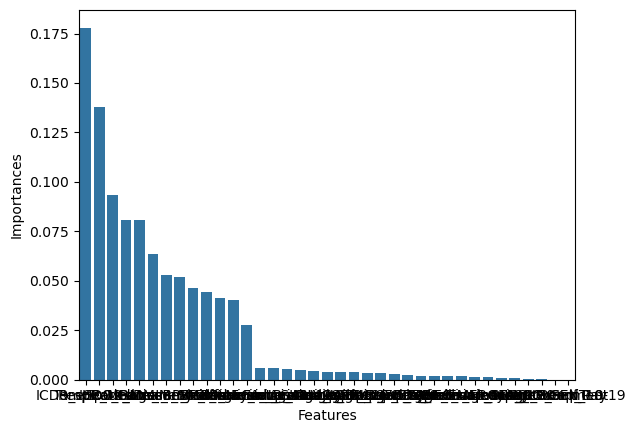

In [ ]:
import seaborn as sns
top_n = 50 #display only the top 50 features
top_features = important_features[:top_n]
aux_top = pd.DataFrame(top_features, columns=['Features', 'Importances'])
ax = sns.barplot(x='Features', y='Importances', data=aux_top)

We can clearly see that the first couple of features as seen in the table are clearly the most important. The importance of the others increases gradually.

In [ ]:
# Filter rows where the 'Features' column starts with 'Insurance'
insurance_rows = aux[aux['Features'].str.startswith('insurance')]
print(insurance_rows)


                Features  Importances
34    insurance_Medicare     5.461176
35     insurance_Private     5.354617
33    insurance_Medicaid     2.617432
32  insurance_Government     0.558325
36    insurance_Self Pay     0.023528


The insurance is not very important compared to some other features. Interestingly. Medicare is most important in predicting, so they may have customers that correlate to a specific LOS.

We check the same for our other base model XGB:

In [ ]:
#Access the best fitted model from the GridSearchCV
best_rf_model = grid_search_XGB.best_estimator_
# Retrieve the feature importances from the best model
importances = best_rf_model.feature_importances_
aux=pd.DataFrame(zip(X.columns, importances),columns=['Features','Importances'])
aux=aux.sort_values(['Importances'],ascending=False)
aux['Importances']=100*aux['Importances']/aux.Importances.max()
aux


,Features,Importances
14,AgeGroup_20-29,100.000000
1,ICD9_encoded,84.853279
30,First_careunit_SICU,77.086166
33,insurance_Medicaid,72.410942
2,HeartRate_Mean,65.072289
7,TempC_Mean,60.230286
18,AgeGroup_60-69,60.118576
6,RespRate_Mean,59.564190
28,First_careunit_CSRU,53.589336
34,insurance_Medicare,50.058880


In [ ]:
# Filter rows where the 'Features' column starts with 'Insurance'
insurance_rows = aux[aux['Features'].str.startswith('insurance')]
print(insurance_rows)


                Features  Importances
33    insurance_Medicaid    72.410942
34    insurance_Medicare    50.058880
35     insurance_Private    35.915104
32  insurance_Government     9.105711
36    insurance_Self Pay     0.000000


Very interestingly, the features of the XGBoost model comared to the RandomForest model are very different. This shows that they use  different algorithms with different underlying mechanics for calculating feature importance.

However, Insurance is more important in this model and Medicaid is the most important and not medicare.

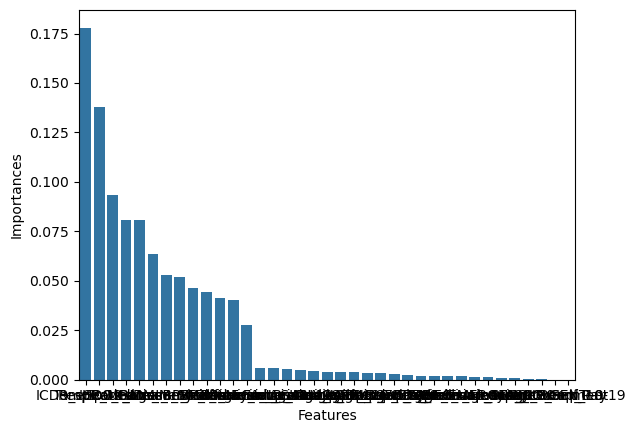

In [ ]:
import seaborn as sns
top_n = 50 #display only the top 50 features
top_features = important_features[:top_n]
aux_top = pd.DataFrame(top_features, columns=['Features', 'Importances'])
ax = sns.barplot(x='Features', y='Importances', data=aux_top)

## Kaggle submission

In [ ]:
test_predictions_submit = pd.DataFrame({"icustay_id": X_test["icustay_id"], "LOS": y_hat_test})
test_predictions_submit.to_csv("Data/test_predictions_submit_2.csv", index = False)

After uploading the corresponding predictions to Kaggle, we see that they improved significantly. We thus opt to use this stacking_model as our final model used to predict the lables of X_test.